In [1]:
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pywt, math

import seaborn as sns
import matplotlib

from matplotlib import pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model, save_model

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

/home/fyp_rm2022/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import time

apple = pd.read_csv("APPLE.csv", encoding="utf8").set_index("Date").Actual_Price
ls  = [time.strftime("%Y-%m-%d", time.strptime(i, "%Y/%m/%d")) for i in apple.index]
apple.index = ls
# df = pd.read_csv("newdata.csv", encoding="utf8").set_index("Date")
# display(df.head())
tmp = pd.read_csv("sp500.csv", encoding="utf8")
tmp = tmp.set_index("Date")
tmp["APPLE"] = apple
df = tmp

In [3]:
np.sum(df.isna())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
APPLE        0
dtype: int64

In [4]:
df = df.dropna(axis=0)
df

,Open,High,Low,Close,Adj Close,Volume,APPLE
Date,,,,,,,
2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000,24.199888
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,24.220579
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,23.613626
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,23.151514
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,22.174414
...,...,...,...,...,...,...,...
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2194630000,176.055695
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2264120000,180.100540
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2217050000,179.061859


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,APPLE
count,1511.000000,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03,1511.000000
mean,2947.316538,2961.847816,2931.637115,2947.931388,2947.931388,3.869822e+09,65.162859
std,715.939142,719.455673,713.133588,716.565165,716.565165,1.026917e+09,41.670392
min,1833.400024,1847.000000,1810.099976,1829.079956,1829.079956,1.296540e+09,21.009537
25%,2431.929932,2441.444946,2420.329956,2432.114990,2432.114990,3.251605e+09,35.896086
50%,2797.360107,2808.919922,2781.810059,2798.290039,2798.290039,3.620220e+09,46.565548
75%,3278.890015,3287.019897,3253.160034,3275.359985,3275.359985,4.182010e+09,90.426166
max,4795.490234,4808.930176,4780.040039,4793.060059,4793.060059,9.878040e+09,180.100540


In [6]:
np.sum(df.isna())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
APPLE        0
dtype: int64

# Visualization

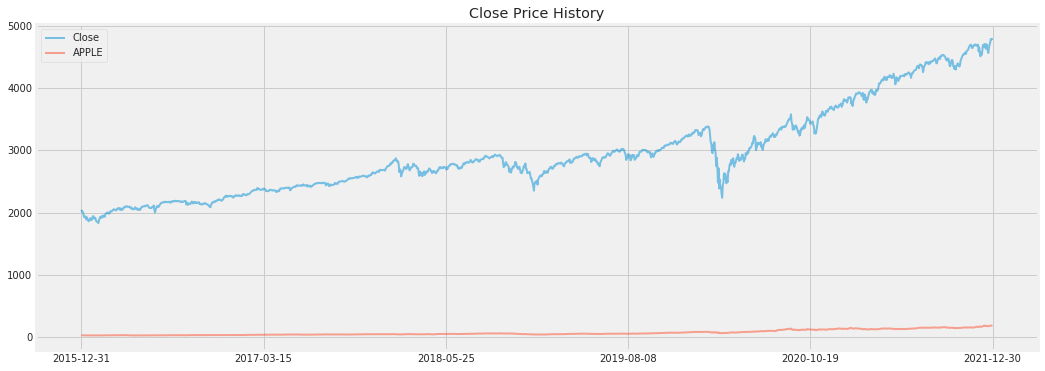

In [7]:
idx = np.array(list(df.index))

plt.figure(figsize=(16,6))
plt.title('Close Price History')
# plt.plot(df[["APPLE", "NVDA", "MSFT", "INTC", "GOOD", "NZ"]], alpha=.5, linewidth=2)
plt.plot(df[['Close', 'APPLE']], alpha=.5, linewidth=2)
plt.legend(['Close', 'APPLE'], loc='upper left')
plt.xticks([0, len(idx)//5, len(idx)//5*2, len(idx)//5*3, len(idx)//5*4, len(idx)-1], idx[[0, len(idx)//5, len(idx)//5*2, len(idx)//5*3, len(idx)//5*4, len(idx)-1]])
plt.show()

# Build up Models

In [8]:
def standardize(df, col=[], mu=None, st=None):
    """
        Func:
            to standardize the specific columns
        
        Args:
            df: the feature data frame without label y
            col: the columns that you want to standardize
                 default to be all columns.
                 
        Returns:
            1. The standardized data.
            2. the mean
            3. the standard variance
    """
    if col == []:
        col = df.columns
    tmp = df.copy()
    flag = False
    if st == None or mu == None:
        st, mu = df[col].std(), df[col].mean()
        flag = True
    tmp[col] = (df[col]-mu)/st
    if flag:
        return tmp, mu, st
    else:
        return tmp



from tqdm import tqdm
from sklearn.model_selection import train_test_split

def take_windows(df, scales=[], window_len=60, sep=.8, y_col=-1):
    """
        Func:
            To take the windows preparing the data for training NN models
            
        Args:
            df: the origin price dataframe
            scalse: a list - which columns we should standardize
            window_len: how many days a window covered (a batch) - default to be 60 days
            sep: the proportion of the training set. set to False to advoid seperation
            y_col: which column is y label
    """
    scaled_data, mu, st = standardize(df, scales)
    # Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    
    # find the column label
    col = scaled_data.columns
    if y_col != -1:
        y_col = list(col).index(y_col)
    
    with tqdm(total=len(scaled_data)-window_len) as pbar:
        pbar.set_description('Processing')
        for i in range(window_len, len(scaled_data)):
            x_train.append(np.array(scaled_data.iloc[i-window_len:i, :]))
            y_train.append(np.array(scaled_data.iloc[i, y_col]))
            pbar.update(1) # update the processing bar

    # Convert the x_train and y_train to numpy arrays 
    #print(x_train)
    x_train, y_train = np.array(x_train), np.array(y_train)

    # Reshape the data
    if len(x_train.shape) < 3:
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    if scales == []:
        if sep:
            sep_items = int(np.ceil(sep * len(y_train)))
            x_test = x_train[sep_items:, :, :]
            x_train = x_train[:sep_items, :, :]
            y_test = y_train[sep_items:]
            y_train = y_train[:sep_items]
            return x_train, y_train, x_test, y_test

        return x_train, y_train
    else:
        if sep:
            sep_items = int(np.ceil(sep * len(y_train)))
            x_test = x_train[sep_items:, :, :]
            x_train = x_train[:sep_items, :, :]
            y_test = y_train[sep_items:]
            y_train = y_train[:sep_items]
            return x_train, y_train, x_test, y_test, mu, st

        return x_train, y_train, mu, st

In [9]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'APPLE'], dtype='object')

In [10]:
# apple   = df[["APPLE", "APPLE_denoised", "APPLE_MACD"]]
# nvda    = df[["NVDA", "NVDA_denoised", "NVDA_MACD"]]
# msft    = df[["MSFT", "MSFT_denoised", "MSFT_MACD"]]
# intc    = df[["INTC", "INTC_denoised", "INTC_MACD"]]
# good    = df[["GOOD", "GOOD_denoised", "GOOD_MACD"]]
mix     = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'APPLE']]
mix

,Open,High,Low,Close,Adj Close,Volume,APPLE
Date,,,,,,,
2015-12-31,2060.590088,2062.540039,2043.619995,2043.939941,2043.939941,2655330000,24.199888
2016-01-04,2038.199951,2038.199951,1989.680054,2012.660034,2012.660034,4304880000,24.220579
2016-01-05,2013.780029,2021.939941,2004.170044,2016.709961,2016.709961,3706620000,23.613626
2016-01-06,2011.709961,2011.709961,1979.050049,1990.260010,1990.260010,4336660000,23.151514
2016-01-07,1985.319946,1985.319946,1938.829956,1943.089966,1943.089966,5076590000,22.174414
...,...,...,...,...,...,...,...
2021-12-23,4703.959961,4740.740234,4703.959961,4725.790039,4725.790039,2194630000,176.055695
2021-12-27,4733.990234,4791.490234,4733.990234,4791.189941,4791.189941,2264120000,180.100540
2021-12-28,4795.490234,4807.020020,4780.040039,4786.350098,4786.350098,2217050000,179.061859


In [11]:
training_x, training_y, test_x, test_y, mu, st = take_windows(mix, scales=list(mix.columns),
                                                              window_len=60, sep=.8, y_col="APPLE")
training_x.shape

Processing: 100%|██████████| 1451/1451 [00:00<00:00, 6989.49it/s]


(1161, 60, 7)

In [12]:
training_y.shape

(1161,)

In [13]:
test_x.shape

(290, 60, 7)

In [29]:
class ResBlock:
    def __init__(self, f, k, s):
        self.filter = f
        self.kernel = k
        self.step   = s
        
    def __call__(self, X_input):
        # ResBlock
        X_short = Conv1D(filters=self.filter, kernel_size=self.kernel, strides=self.step, data_format='channels_last')(X_input)
#         X_short = BatchNormalization()(X_short)
        #X_short = ReLU()(X_short)
        X       = Conv1D(filters=self.filter//2, kernel_size=self.kernel, strides=1, data_format='channels_last')(X_input)
#         X       = BatchNormalization()(X)
        X       = ReLU()(X)

        X       = Conv1D(filters=self.filter, kernel_size=1, strides=self.step, data_format='channels_last')(X)
#         X       = BatchNormalization()(X)
        # X       = ReLU()(X)

        X       = Add()([X_short, X])
        X       = ReLU()(X)
        
        return X
    

def res_lstm(input_shape = (5)):
    X_input = Input(input_shape)
    
    # ResBlock
    X       = ResBlock(60, 30, 2)(X_input)
    X       = ResBlock(120, 10, 2)(X)
    X       = ResBlock(240, 3, 1)(X)
#     X_short = Conv1D(filters=60, kernel_size=30, strides=1, data_format='channels_last')(X_input)
#     #X_short = ReLU()(X_short)
#     X       = Conv1D(filters=30, kernel_size=10, strides=2, data_format='channels_last')(X_input)
#     X       = ReLU()(X)
    
#     X       = Conv1D(filters=60, kernel_size=1, strides=1, data_format='channels_last')(X)
#     X       = ReLU()(X)
    
#     X       = Add()([X_short, X])
    
#     X = Flatten()(X)
    #X = Dense(60, activation='relu', kernel_regularizer='l2')(X_input)
    #X = LSTM(60, return_sequences=True)(X)
#     X = AveragePooling1D(2)(X)
    X = LSTM(80, activation='relu', return_sequences=True)(X)
#     X = Dropout(.2, input_shape=(30, 30))(X)
    X = LSTM(50, activation='relu', return_sequences=True)(X)
    X = Dropout(.2, input_shape=(30, 15))(X)
    X = LSTM(30, activation='relu', return_sequences=True)(X)
    #X = LSTM(8, activation='relu', return_sequences=True)(X)
    X = Flatten()(X)
    X = Dense(12, activation='relu', kernel_regularizer='l2')(X)
    X = Dense(1, activation='relu')(X)
  
    model = Model(inputs = X_input, outputs = X)
 
    return model

In [30]:
model = res_lstm((60, 7))
print(model.summary())

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 60, 7)]      0           []                               
                                                                                                  
 conv1d_28 (Conv1D)             (None, 31, 30)       6330        ['input_4[0][0]']                
                                                                                                  
 re_lu_18 (ReLU)                (None, 31, 30)       0           ['conv1d_28[0][0]']              
                                                                                                  
 conv1d_27 (Conv1D)             (None, 16, 60)       12660       ['input_4[0][0]']                
                                                                                            

In [31]:
np.sum(np.isnan(test_x))

0

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01), loss='mae', metrics=['mse', 'mae'])
hitory = model.fit(training_x, training_y, epochs=30, batch_size=512, validation_data=(test_x, test_y))
model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mae', metrics=['mse', 'mae'])
hitory1 = model.fit(training_x, training_y, epochs=50, batch_size=512, validation_data=(test_x, test_y))
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='mae', metrics=['mse', 'mae'])
hitory2 = model.fit(training_x, training_y, epochs=50, batch_size=512, validation_data=(test_x, test_y))

Epoch 1/30
3/3 [==============================] - 3s 213ms/step - loss: 0.8142 - mse: 0.4703 - mae: 0.6111 - val_loss: 1.8791 - val_mse: 3.2855 - val_mae: 1.7180
Epoch 2/30
3/3 [==============================] - 0s 35ms/step - loss: 0.7394 - mse: 0.4329 - mae: 0.5879 - val_loss: 1.4638 - val_mse: 1.8645 - val_mae: 1.3425
Epoch 3/30
3/3 [==============================] - 0s 34ms/step - loss: 0.7088 - mse: 0.4420 - mae: 0.5950 - val_loss: 1.8351 - val_mse: 3.1748 - val_mae: 1.7445
Epoch 4/30
3/3 [==============================] - 0s 37ms/step - loss: 0.6796 - mse: 0.4426 - mae: 0.5947 - val_loss: 1.8117 - val_mse: 3.1748 - val_mae: 1.7445
Epoch 5/30
3/3 [==============================] - 0s 34ms/step - loss: 0.6617 - mse: 0.4477 - mae: 0.5988 - val_loss: 0.3165 - val_mse: 0.0954 - val_mae: 0.2670
Epoch 6/30
3/3 [==============================] - 0s 33ms/step - loss: 0.6162 - mse: 0.4089 - mae: 0.5699 - val_loss: 0.7557 - val_mse: 0.5762 - val_mae: 0.7189
Epoch 7/30
3/3 [=================

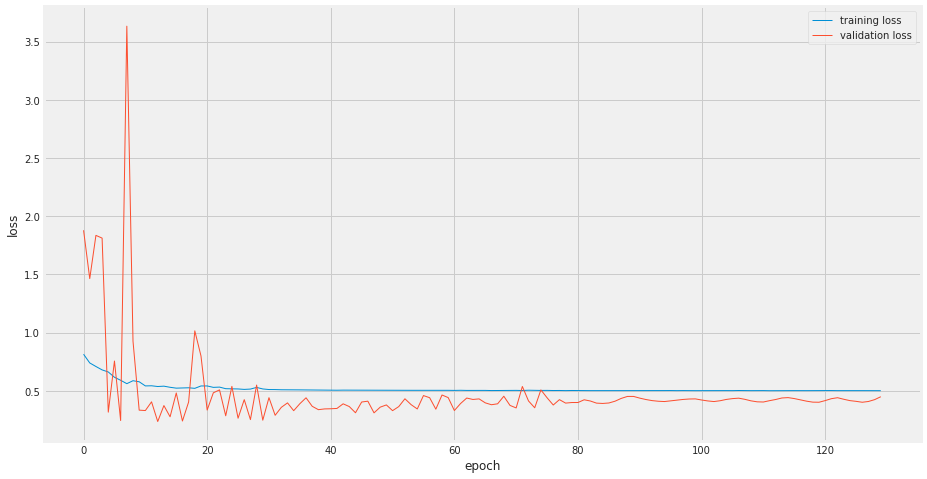

In [33]:
loss = hitory.history["loss"] + hitory1.history["loss"] + hitory2.history["loss"]
val_loss = hitory.history["val_loss"] + hitory1.history["val_loss"] + hitory2.history["val_loss"]
plt.rcParams['figure.figsize'] = (14, 8)
plt.plot(loss, label="training loss", linewidth=1)
plt.plot(val_loss, label="validation loss", linewidth=1)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.show()

# Model Evaluation

In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [35]:
mean_absolute_error(model.predict(test_x), test_y)*st["APPLE"]+mu["APPLE"]

83.86254283480577

In [36]:
mean_squared_error(model.predict(test_x), test_y)*st["APPLE"]+mu["APPLE"]

77.23970507184183

In [37]:
np.sqrt(mean_squared_error(model.predict(test_x), test_y)*st["APPLE"]+mu["APPLE"])

8.788612238109144

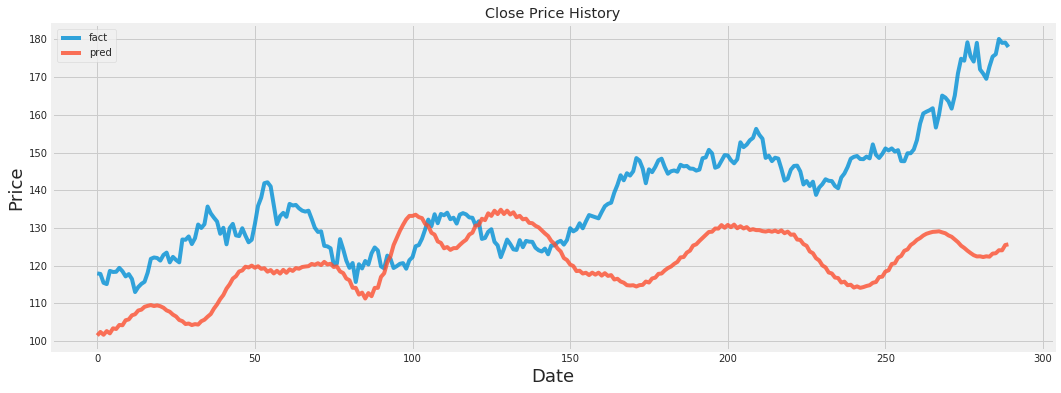

In [38]:
y_pred = model.predict(test_x)
y_pred = np.reshape(y_pred, (y_pred.shape[0],))

plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(pd.DataFrame({"fact": test_y*st["APPLE"]+mu["APPLE"], "pred": y_pred*st["APPLE"]+mu["APPLE"]}), alpha=.8)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.legend(['fact', 'pred'], loc='upper left')
plt.show()

In [39]:
model.save("res_lstm.h5")

## Testing the Accuracy

In [40]:
def heatmap(df):
    plt.figure(figsize = (6, 5))
    sns.set(font_scale=1.5)
    sns.heatmap(df, annot = True, cmap = "RdBu", linewidths = 0.05, annot_kws = {"size": 30})
    plt.show()

def score(pred_y, y, show=False, mute=False):
    """
        Args:
            pred_y: our model's prediction
            y: the actual result
            show: whether show the visualization
            mute: default to be False. If true, nothing will be printed
        Returns:
            1. the accurary
            2. the f1-score (acc as positive)
            3. the f1-score (unacc as positive)
    """
    y = pd.DataFrame(list(y))
    pred_y = pd.DataFrame(pred_y)# Change the numbers into strings
    if (pred_y[pred_y.columns[0]]==1).any():
        pred_y[pred_y[pred_y.columns[0]]==1] = "acc"
        pred_y[pred_y[pred_y.columns[0]]==-1] = "unacc"
        y[y[y.columns[0]]==1] = "acc"
        y[y[y.columns[0]]==-1] = "unacc"
    idx_yn = np.array(y=="unacc")
    idx_yp = ~idx_yn
    
    y_n = y[idx_yn]
    pred_y_n = pred_y[idx_yn]
    y_p = y[idx_yp]
    pred_y_p = pred_y[idx_yp]
    
    tp = (y_p==pred_y_p).sum()
    tn = (y_n==pred_y_n).sum()
    fp = (y_p!=pred_y_p).sum()
    fn = (y_n!=pred_y_n).sum()
    
    acc = (tp+tn)/len(y)
    precision = tp/(tp + fp)
    recall = tp/(tp + fn)
    f1_p = 2 * precision * recall / (precision + recall)
    precision = tn/(tn + fn)
    recall = tn/(tn + fp)
    f1_n = 2 * precision * recall / (precision + recall)
    
    if mute:
        return acc, f1_p, f1_n
    print("Using acc as positive:")
    print("\tThe accuracy: %f"%acc)
    print("\tThe F1-score: %f"%f1_p)
    print("Using unacc as positive:")
    print("\tThe accuracy: %f"%acc)
    print("\tThe F1-score: %f"%f1_n)
    if show:
        tmp = pd.DataFrame({"pred Pos":[tp[0], fp[0]], "pred Neg":[fn[0], tn[0]]},
        index=["real Pos", "real Neg"])
        heatmap(tmp)
    return acc, f1_p, f1_n

Using acc as positive:
	The accuracy: 0.529412
	The F1-score: 0.488722
Using unacc as positive:
	The accuracy: 0.529412
	The F1-score: 0.564103


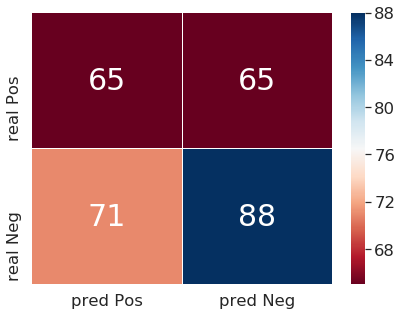

(0    0.529412
 dtype: float64, 0    0.488722
 dtype: float64, 0    0.564103
 dtype: float64)

In [41]:
def get_trend(value):
    trend = value[:-1] - value[1:]
    trend[trend > 0] = 1
    trend[trend < 0] = -1
    return trend

pred_trend  = get_trend(y_pred)
truth_trend = get_trend(test_y)
score(pred_trend, truth_trend, show = True)